# **Breast Cancer Prediction**

## **Objective**
To develop a predictive model for breast cancer diagnosis using features computed from digitized images of fine needle aspirates (FNA) of breast masses. The goal is to accurately classify tumors as malignant or benign based on the characteristics of cell nuclei present in the images.

## **Data Source**
The dataset is available from:

- **UW CS ftp server:** ftp.cs.wisc.edu (path: math-prog/cpo-dataset/machine-learn/WDBC/)
- **UCI Machine Learning Repository:** https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

## **Attribute Information**
The dataset contains 32 attributes:
- **ID number**
- **Diagnosis:** Binary classification (M = malignant, B = benign)
- **Features:** 30 real-valued features computed for each cell nucleus. These features are calculated based on the following ten characteristics:
  - **Radius:** Mean of distances from center to points on the perimeter
  - **Texture:** Standard deviation of gray-scale values
  - **Perimeter**
  - **Area**
  - **Smoothness:** Local variation in radius lengths
  - **Compactness:** (perimeter<sup>2</sup>/area−1.0)(perimeter<sup>2</sup>/area-1.0)
  - **Concavity:** Severity of concave portions of the contour
  - **Concave points:** Number of concave portions of the contour
  Symmetry
  - **Fractal dimension:** "Coastline approximation" - 1

  Each characteristic is computed in three ways:

  - **Mean**
  - **Standard Error (SE)**
  - **Worst or largest (mean of the three largest values)**

  This results in 30 features per sample, structured as follows:

  - **Fields 3-12:** Mean values
  - **Fields 13-22:** Standard Error (SE) values
  - **Fields 23-32:** Worst values

## **Dataset Details:**

- **Number of Samples:** 569
- **Class Distribution:** 357 benign and 212 malignant
- **Feature Values:** Recorded with four significant digits
- **Missing Values:** None

## **Expected Outcome:**
A reliable predictive model that can assist in the diagnosis of breast cancer, helping to distinguish between malignant and benign tumors based on the computed features from FNA images. The model should be able to provide high accuracy and robustness in its predictions, potentially aiding medical professionals in early and accurate diagnosis. This project utilizes the strengths of machine learning to contribute to the field of medical diagnostics, offering a data-driven approach to cancer detection.


In [1]:
# Creating a timestamp
import datetime
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2024-05-28 10:22:31.011172


## **Importing the libraries**

In [2]:
# Essentials
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_inline.config import InlineBackend

%config InlineBackend.figure_format = 'svg'
sns.set(style='whitegrid', palette='rocket')

# Feature Engineering
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier, StackingClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve

# Miscellaneous
import os
import zipfile
import pickle

# Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore')

## **Getting the dataset**

In [3]:
# Function to extract the zipfile
def unzip_file(zip_file_path, extract_to_folder=None):
    if not zipfile.is_zipfile(zip_file_path):
        raise ValueError("The provided file is not a valid zip file")

    if extract_to_folder is None:
        extract_to_folder = os.path.dirname(zip_file_path)

    os.makedirs(extract_to_folder, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)
        print(f"Extracted all files to {extract_to_folder}")

In [4]:
# Unzipping the zip file
zip_file_path = '/content/Breast Cancer Prediction.zip'
extract_to_folder = '/content/data'

unzip_file(zip_file_path, extract_to_folder)

Extracted all files to /content/data


In [5]:
# Storing the data in a dataframe
df = pd.read_csv('/content/data/data.csv')
rows, cols = df.shape
print(f'Total nos. of rows: {rows}')
print(f'Total nos. of columns: {cols}')

Total nos. of rows: 569
Total nos. of columns: 33


## **Exploratory Data Analysis**

### **1. Overview**

In [6]:
# Reviewing the dataset
df.sample(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
403,9047,B,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,0.06200,0.1458,0.9050,0.9975,11.36,0.002887,0.01285,0.01613,0.007308,0.01870,0.001972,13.86,23.02,89.69,580.9,0.1172,0.1958,0.1810,0.08388,0.3297,0.07834,NaN
396,90401601,B,13.51,18.89,88.10,558.1,0.10590,0.11470,0.08580,0.05381,0.1806,0.06079,0.2136,1.3320,1.5130,19.29,0.005442,0.01957,0.03304,0.013670,0.01315,0.002464,14.80,27.20,97.33,675.2,0.1428,0.2570,0.3438,0.14530,0.2666,0.07686,NaN
262,888570,M,17.29,22.13,114.40,947.8,0.08999,0.12730,0.09697,0.07507,0.2108,0.05464,0.8348,1.6330,6.1460,90.94,0.006717,0.05981,0.04638,0.021490,0.02747,0.005838,20.39,27.24,137.90,1295.0,0.1134,0.2867,0.2298,0.15280,0.3067,0.07484,NaN
44,85638502,M,13.17,21.81,85.42,531.5,0.09714,0.10470,0.08259,0.05252,0.1746,0.06177,0.1938,0.6123,1.3340,14.49,0.003350,0.01384,0.01452,0.006853,0.01113,0.001720,16.23,29.89,105.50,740.7,0.1503,0.3904,0.3728,0.16070,0.3693,0.09618,NaN
109,864018,B,11.34,21.26,72.48,396.5,0.08759,0.06575,0.05133,0.01899,0.1487,0.06529,0.2344,0.9861,1.5970,16.41,0.009113,0.01557,0.02443,0.006435,0.01568,0.002477,13.01,29.15,83.99,518.1,0.1699,0.2196,0.3120,0.08278,0.2829,0.08832,NaN


In [7]:
# Total nos. of duplicate rows in the dataset
print(f'Total nos. of identical rows: {df.duplicated().sum()}')

Total nos. of identical rows: 0


In [8]:
# Total nos. of duplicated columns in the dataset
def find_identical_columns(df):
    identical_columns = []
    columns_checked = set()

    for i in range(len(df.columns)):
        col_i = df.columns[i]
        if col_i in columns_checked:
            continue
        identical_group = [col_i]
        for j in range(i+1, len(df.columns)):
            col_j = df.columns[j]
            if col_j in columns_checked:
                continue
            if df[col_i].equals(df[col_j]):
                identical_group.append(col_j)
                columns_checked.add(col_j)
        if len(identical_group) > 1:
            identical_columns.append(identical_group)
        columns_checked.add(col_i)

    return identical_columns

# Find identical columns
identical_columns = find_identical_columns(df)
print(f'Identical columns: {identical_columns}')
print(f'Total nos. of identical columns: {len(identical_columns)}')

Identical columns: []
Total nos. of identical columns: 0


In [9]:
# Total nos. of columns with all NaN value
nan_columns = df.columns[df.isna().all()].tolist()
print(f'Columns with all NaN value: {nan_columns}')
print(f'Total nos. of columns with all NaN value: {len(nan_columns)}')

Columns with all NaN value: ['Unnamed: 32']
Total nos. of columns with all NaN value: 1


**OBSERVATION:**

Since the entire column is composed of **NaN** values, hence, it can be removed directly from the dataset.

In [10]:
# Extracting numerical & categorical features
num_features = [feature for feature in df.select_dtypes(exclude='object')]
cat_features = [feature for feature in df.select_dtypes(include='object')]

print(f"Total nos. of numerical features are: {len(num_features)}")
print(f"Total nos. of categorical features are: {len(cat_features)}")

Total nos. of numerical features are: 32
Total nos. of categorical features are: 1


In [11]:
# Getting information about the features of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [12]:
# Converting datatype of target feature to numerical
df['diagnosis']=[1 if i.strip()=='M' else 0 for i in df['diagnosis']]
df.sample(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
97,862261,0,9.787,19.94,62.11,294.5,0.10240,0.05301,0.006829,0.007937,0.1350,0.06890,0.3350,2.0430,2.132,20.05,0.011130,0.01463,0.005308,0.005250,0.01801,0.005667,10.92,26.29,68.81,366.1,0.1316,0.09473,0.02049,0.02381,0.1934,0.08988,NaN
400,90439701,1,17.910,21.02,124.40,994.0,0.12300,0.25760,0.318900,0.119800,0.2113,0.07115,0.4030,0.7747,3.123,41.51,0.007159,0.03718,0.061650,0.010510,0.01591,0.005099,20.80,27.78,149.60,1304.0,0.1873,0.59170,0.90340,0.19640,0.3245,0.11980,NaN
502,91505,0,12.540,16.32,81.25,476.3,0.11580,0.10850,0.059280,0.032790,0.1943,0.06612,0.2577,1.0950,1.566,18.49,0.009702,0.01567,0.025750,0.011610,0.02801,0.002480,13.57,21.40,86.67,552.0,0.1580,0.17510,0.18890,0.08411,0.3155,0.07538,NaN
456,9112366,0,11.630,29.29,74.87,415.1,0.09357,0.08574,0.071600,0.020170,0.1799,0.06166,0.3135,2.4260,2.150,23.13,0.009861,0.02418,0.042750,0.009215,0.02475,0.002128,13.12,38.81,86.04,527.8,0.1406,0.20310,0.29230,0.06835,0.2884,0.07220,NaN
76,8610629,0,13.530,10.94,87.91,559.2,0.12910,0.10470,0.068770,0.065560,0.2403,0.06641,0.4101,1.0140,2.652,32.65,0.013400,0.02839,0.011620,0.008239,0.02572,0.006164,14.08,12.49,91.36,605.5,0.1451,0.13790,0.08539,0.07407,0.2710,0.07191,NaN


In [13]:
# Checking the statistics of the dataset
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


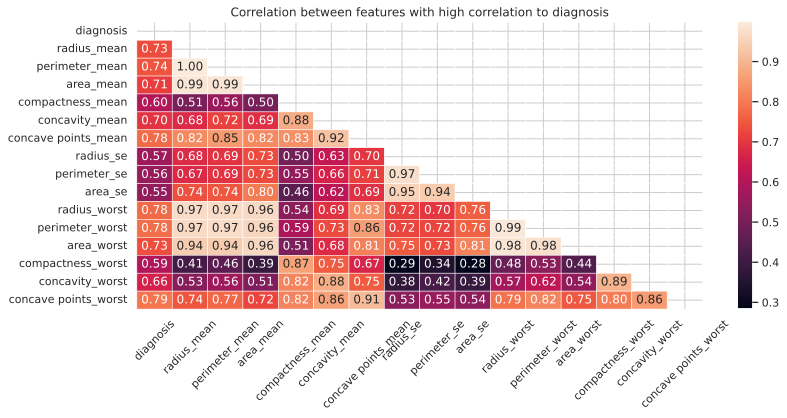

In [14]:
# Correlation between features with high correlation to diagnosis
corr_matrix = df.drop(columns=['id', 'Unnamed: 32']).corr()
diag_corr = corr_matrix['diagnosis']
high_corr_features = diag_corr[diag_corr.abs() >= 0.5].index
filtered_corr_matrix = df[high_corr_features].corr()

plt.figure(figsize=(12, 6))
mask = np.triu(np.ones_like(filtered_corr_matrix, dtype=bool))
sns.heatmap(filtered_corr_matrix, annot=True, linewidths=0.5, fmt=".2f", mask=mask).set(facecolor='white')
plt.xticks(rotation=45)
plt.title('Correlation between features with high correlation to diagnosis')
plt.tight_layout()

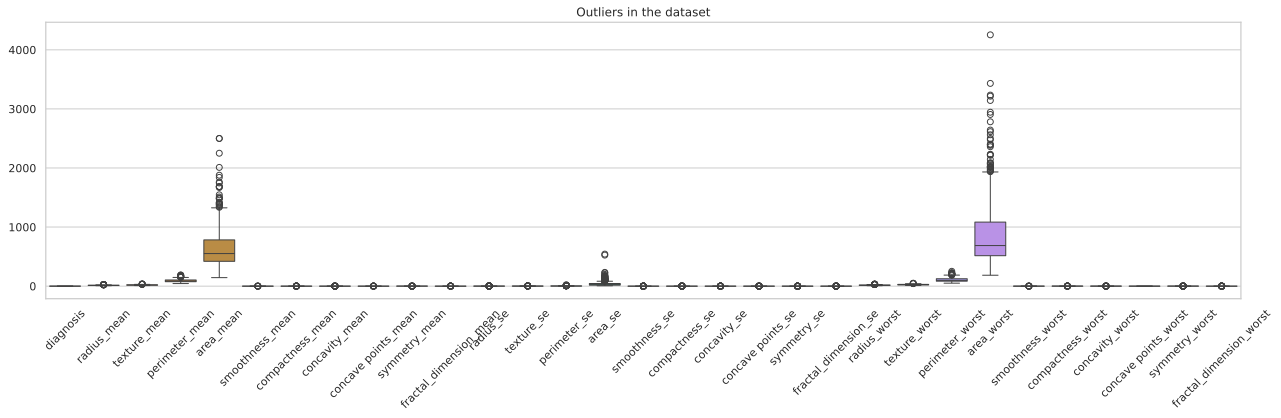

In [15]:
# Outlier detection in the dataset
plt.figure(figsize=(18,6))
sns.boxplot(data=df.drop(columns=['id','Unnamed: 32']))
plt.xticks(rotation=45)
plt.title('Outliers in the dataset')
plt.tight_layout()

### **2. Missing values**

In [16]:
# Missing values in the dataset
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

### **3. Target Distribution**

In [17]:
# Count of malignant & benign patients
cancer_count = df['diagnosis'].value_counts()

# Percentage of malignant & benign patients
cancer_percent = np.round(df['diagnosis'].value_counts()/len(df)*100, 2)

pd.concat([cancer_count, cancer_percent], keys=['Count', 'Percentage(%)'], axis=1)

,Count,Percentage(%)
diagnosis,,
0,357,62.74
1,212,37.26


### **4. Feature Distribution**

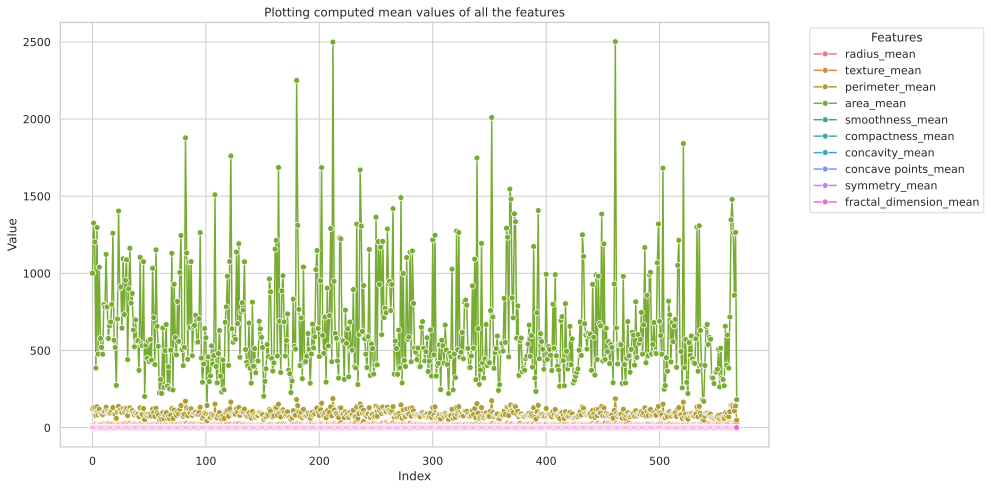

In [18]:
# Plotting computed mean values of all the features
mean_columns = [col for col in df.columns if col.endswith('mean')]
mean_data_long = df[mean_columns].reset_index().melt(id_vars='index', var_name='feature', value_name='value')

plt.figure(figsize=(14, 7))
sns.lineplot(data=mean_data_long, x='index', y='value', hue='feature', marker='o')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plotting computed mean values of all the features')
plt.xlabel('Index')
plt.ylabel('Value')
plt.tight_layout()

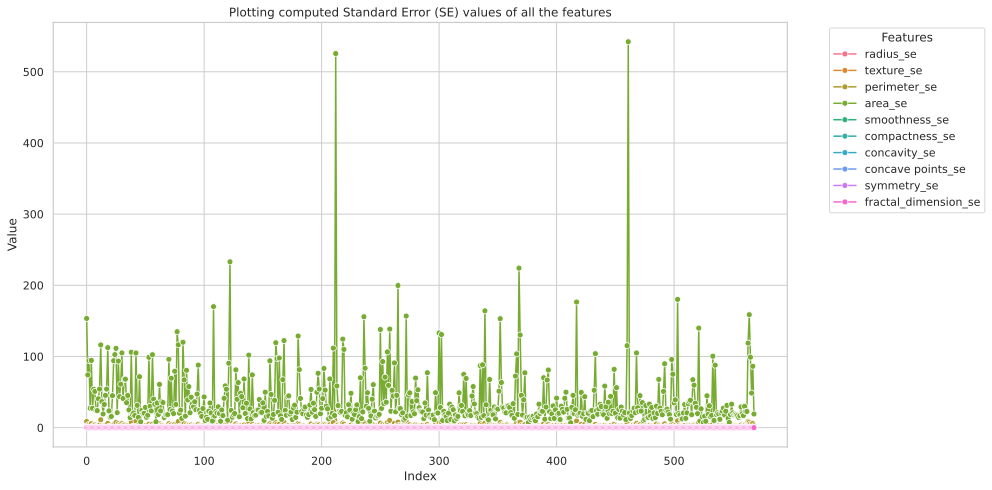

In [19]:
# Plotting computed Standard Error (SE) values of all the features
mean_columns = [col for col in df.columns if col.endswith('se')]
mean_data_long = df[mean_columns].reset_index().melt(id_vars='index', var_name='feature', value_name='value')

plt.figure(figsize=(14, 7))
sns.lineplot(data=mean_data_long, x='index', y='value', hue='feature', marker='o')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plotting computed Standard Error (SE) values of all the features')
plt.xlabel('Index')
plt.ylabel('Value')
plt.tight_layout()

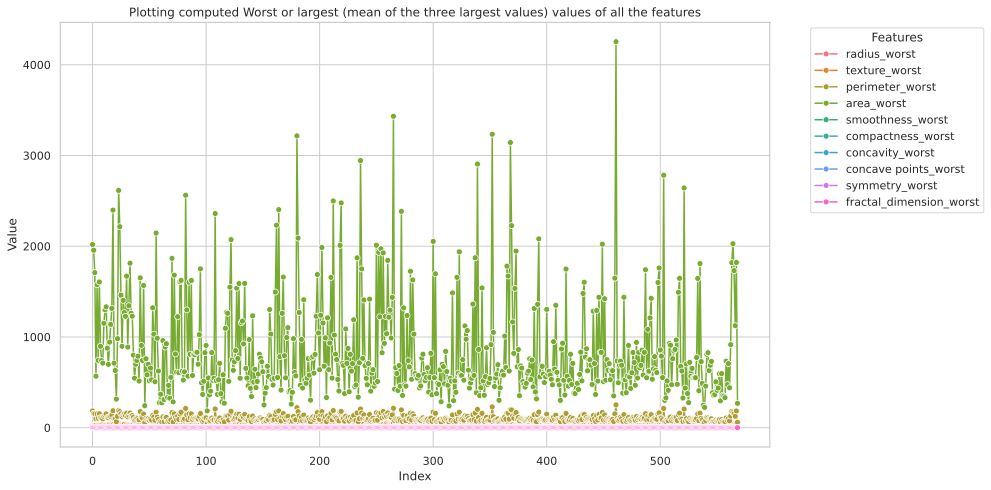

In [20]:
# Plotting computed Worst or largest (mean of the three largest values) values of all the features
mean_columns = [col for col in df.columns if col.endswith('worst')]
mean_data_long = df[mean_columns].reset_index().melt(id_vars='index', var_name='feature', value_name='value')

plt.figure(figsize=(14, 7))
sns.lineplot(data=mean_data_long, x='index', y='value', hue='feature', marker='o')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Plotting computed Worst or largest (mean of the three largest values) values of all the features')
plt.xlabel('Index')
plt.ylabel('Value')
plt.tight_layout()

## **Feature Engineering**

In [21]:
# Seperating target column from rest of the dataset
y = df['diagnosis']
y.sample(5)

463    0
482    0
210    1
45     1
559    0
Name: diagnosis, dtype: int64

In [22]:
# Dropping id, diagnosis feature from the dataset
X = df.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
X.sample(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
483,13.70,17.64,87.76,571.1,0.09950,0.07957,0.04548,0.031600,0.1732,0.06088,0.2431,0.9462,1.564,20.640,0.003245,0.008186,0.016980,0.009233,0.01285,0.001524,14.96,23.53,95.78,686.5,0.11990,0.13460,0.17420,0.09077,0.2518,0.06960
436,12.87,19.54,82.67,509.2,0.09136,0.07883,0.01797,0.020900,0.1861,0.06347,0.3665,0.7693,2.597,26.500,0.005910,0.013620,0.007066,0.006502,0.02223,0.002378,14.45,24.38,95.14,626.9,0.12140,0.16520,0.07127,0.06384,0.3313,0.07735
377,13.46,28.21,85.89,562.1,0.07517,0.04726,0.01271,0.011170,0.1421,0.05763,0.1689,1.1500,1.400,14.910,0.004942,0.012030,0.007508,0.005179,0.01442,0.001684,14.69,35.63,97.11,680.6,0.11080,0.14570,0.07934,0.05781,0.2694,0.07061
443,10.57,18.32,66.82,340.9,0.08142,0.04462,0.01993,0.011110,0.2372,0.05768,0.1818,2.5420,1.277,13.120,0.010720,0.013310,0.019930,0.011110,0.01717,0.004492,10.94,23.31,69.35,366.3,0.09794,0.06542,0.03986,0.02222,0.2699,0.06736
231,11.32,27.08,71.76,395.7,0.06883,0.03813,0.01633,0.003125,0.1869,0.05628,0.1210,0.8927,1.059,8.605,0.003653,0.016470,0.016330,0.003125,0.01537,0.002052,12.08,33.75,79.82,452.3,0.09203,0.14320,0.10890,0.02083,0.2849,0.07087


In [23]:
# Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((455, 30), (455,), (114, 30), (114,))

### **1. Handling Numerical Features**

In [24]:
# Scaling all the numerical features
scaler = StandardScaler()

X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

X_train_transformed.shape, X_test_transformed.shape

((455, 30), (114, 30))

### **2. Principal Component Analysis**

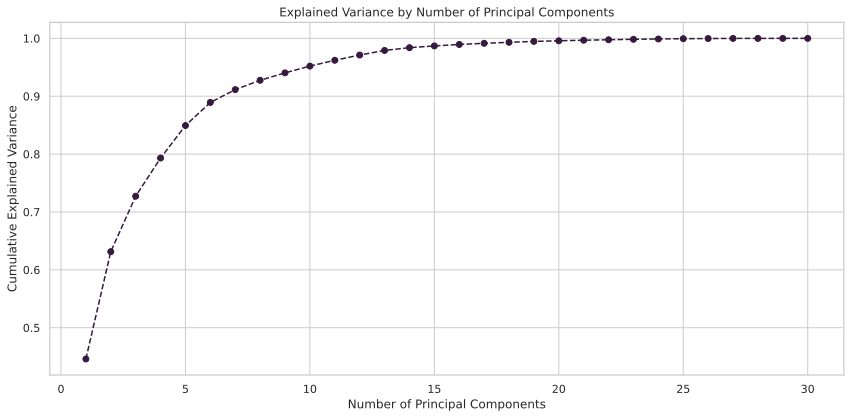

In [25]:
# Explained Variance by Number of Principal Components
pca = PCA()
pca.fit(X_train_transformed)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.tight_layout()

In [26]:
# Finding the number of components required to explain at least 90% of the variance
print(f"Total nos. of components required to explain at least 90% variance: {np.argmax(cumulative_variance >= 0.9) + 1}")

Total nos. of components required to explain at least 90% variance: 7


### **3. Conclusion**

In [27]:
# Downloading the train & test data
train_final = pd.concat([pd.DataFrame(X_train_transformed), y_train], axis=1)
test_final = pd.concat([pd.DataFrame(X_test_transformed), y_test], axis=1)

train_final.to_csv('/content/data/training_data.csv', index=False)
test_final.to_csv('/content/data/testing_data.csv', index=False)

## **Model Selection**

### **1. Initialising models**

In [28]:
# Linear Model
lr_clf = LogisticRegression()

# Support Vector Machine
svc_clf = SVC()

# K Nearest Neighbours
knc_clf = KNeighborsClassifier()

# Naive Bayes
gnb_clf = GaussianNB()

# Tree Model
dt_clf = DecisionTreeClassifier()

# Ensemble Model
rf_clf = RandomForestClassifier()
abc_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()

# LightGBM Classifier
lgbm_clf = LGBMClassifier(verbosity=-1)

# XGBoost Classifier
xgb_clf = XGBClassifier()

In [29]:
# Defining metrics for evaluation
def metrics(y_test, y_pred):
  accuracy = np.round(accuracy_score(y_test, y_pred), 5)
  precision = np.round(precision_score(y_test, y_pred), 5)
  recall = np.round(recall_score(y_test, y_pred), 5)
  f1 = np.round(f1_score(y_test, y_pred), 5)

  return accuracy, precision, recall, f1

### **2. Making predictions**

In [30]:
# Extracting all the initialised models
models = [lr_clf, svc_clf, knc_clf, gnb_clf, dt_clf, rf_clf, abc_clf, gb_clf, lgbm_clf, xgb_clf]

In [31]:
# Function to make predictions using initialised models
def make_predictions(X_train, X_test, y_train, y_test, lst_models, lst_scores):
  for model in lst_models:
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)

    accuracy, precision, recall, f1 = metrics(y_test, model_pred)

    val_score = np.round(cross_val_score(model, X_train, y_train, cv=3).mean(), 5)

    lst_scores.append([type(model).__name__, accuracy, precision, recall, f1, val_score])

In [32]:
# Storing prediction outcomes in a dataframe
scores = []
make_predictions(X_train_transformed, X_test_transformed, y_train, y_test, models, scores)

In [33]:
# Storing predictions in a dataframe
df_pred = pd.DataFrame(scores, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'Val score'])
df_pred

,Model,Accuracy,Precision,Recall,F1 score,Val score
0,LogisticRegression,0.96491,0.97500,0.92857,0.95122,0.97363
1,SVC,0.97368,1.00000,0.92857,0.96296,0.97801
2,KNeighborsClassifier,0.95614,0.97436,0.90476,0.93827,0.96700
3,GaussianNB,0.92105,0.92308,0.85714,0.88889,0.93845
4,DecisionTreeClassifier,0.91228,0.90000,0.85714,0.87805,0.92303
5,RandomForestClassifier,0.96491,1.00000,0.90476,0.95000,0.95380
6,AdaBoostClassifier,0.96491,0.97500,0.92857,0.95122,0.95161
7,GradientBoostingClassifier,0.96491,1.00000,0.90476,0.95000,0.95819
8,LGBMClassifier,0.96491,1.00000,0.90476,0.95000,0.96040
9,XGBClassifier,0.95614,1.00000,0.88095,0.93671,0.95600


Text(0.5, 1.0, 'Model predictions on testing set')

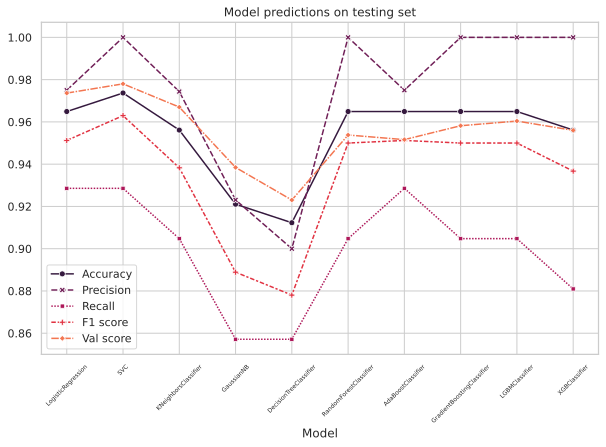

In [34]:
# Plotting the predictions of models
plt.figure(figsize=(10,6))
sns.lineplot(df_pred.set_index('Model'), markers=True)
plt.xticks(fontsize=6, rotation=45)
plt.title('Model predictions on testing set')

### **3. Hyperparameter Tuning**

In [35]:
# Hyperparameters of each model
param_grid = {
    'logistic_regression': {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1],
        'max_iter' : [100, 500, 1000],
    },

    'support_vector_classifier': {
        'C': [0.01, 0.1, 1],
        'degree': [3, 5, 7],
        'max_iter' : [100, 500, 1000]
    },

    'kneighbors_classifier': {
        'n_neighbors' : [5, 7, 9, 11],
        'weights' : ['uniform', 'distance']
    },

    'gaussianNB': {
        'var_smoothing': np.logspace(0,-9, num=100)
    },

    'decision_tree_classifier': {
        'criterion': ["gini", "entropy"],
        'max_depth': [5, 7, 9],
        'max_features': ['auto', 'sqrt'],

    },

    'random_forest_classifier': {
        'n_estimators': [10, 50, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 15]
    },

    'adaboost_classifier': {
        "n_estimators" :[10, 50, 100],
        "learning_rate":  [0.001, 0.01]
    },

    'gradient_boosting_classifier': {
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.001, 0.01],
        'max_depth': [5, 7, 9]
    },

    'lgbm_classifier': {
        'max_depth': [5, 7, 9],
        'num_iterations': [100, 500, 1000],
        'learning_rate': [0.001, 0.01],
        'verbosity': [-1]
    },

    'xgboost_classifier': {
        'learning_rate': [0.001, 0.01],
        'max_depth': [5, 7, 9],
        'sampling_method': ['uniform', 'gradient_based']
    }
}

In [36]:
# List to score parameters after hyperparameter tuning
best_scores = []
new_scores = []
parameters = {}

In [37]:
# Function to do hyperparameter tuning on models
def tune_models(X_train, X_test, y_train, y_test, lst_models, param_grid, best_scores, new_scores, parameters):
  param_keys = list(param_grid.keys())
  for idx, model in enumerate(lst_models):
    tune_param = GridSearchCV(model, param_grid[param_keys[idx]], cv=3)
    tune_param.fit(X_train,y_train)
    tune_model_pred = tune_param.predict(X_test)

    accuracy, precision, recall, f1 = metrics(y_test, tune_model_pred)

    parameters[type(model).__name__] = tune_param.best_params_
    best_scores.append([type(model).__name__, tune_param.best_score_])
    new_scores.append([type(model).__name__, accuracy, precision, recall, f1])

In [38]:
# Doing hyperparameter tuning for all the models
tune_models(X_train_transformed, X_test_transformed, y_train, y_test, models, param_grid, best_scores, new_scores, parameters)

In [39]:
# Printing the best parameters for all the model
for idx,param in enumerate(parameters):
  print(param)
  print(f"Best score:{np.round(best_scores[idx][1],5)}")
  print(f"Hyperparameter: {parameters[param]}\n")

LogisticRegression
Best score:0.97363
Hyperparameter: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}

SVC
Best score:0.97801
Hyperparameter: {'C': 1, 'degree': 3, 'max_iter': 100}

KNeighborsClassifier
Best score:0.97139
Hyperparameter: {'n_neighbors': 7, 'weights': 'uniform'}

GaussianNB
Best score:0.94503
Hyperparameter: {'var_smoothing': 0.0657933224657568}

DecisionTreeClassifier
Best score:0.93624
Hyperparameter: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt'}

RandomForestClassifier
Best score:0.96259
Hyperparameter: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 10}

AdaBoostClassifier
Best score:0.93181
Hyperparameter: {'learning_rate': 0.01, 'n_estimators': 50}

GradientBoostingClassifier
Best score:0.93845
Hyperparameter: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 50}

LGBMClassifier
Best score:0.9648
Hyperparameter: {'learning_rate': 0.01, 'max_depth': 7, 'num_iterations': 1000, 'verbosity': -1}

XGBClassifier
Best score:0.9318
Hyperparameter: {

Text(0.5, 1.0, 'Mean cross-validated score of the best estimators')

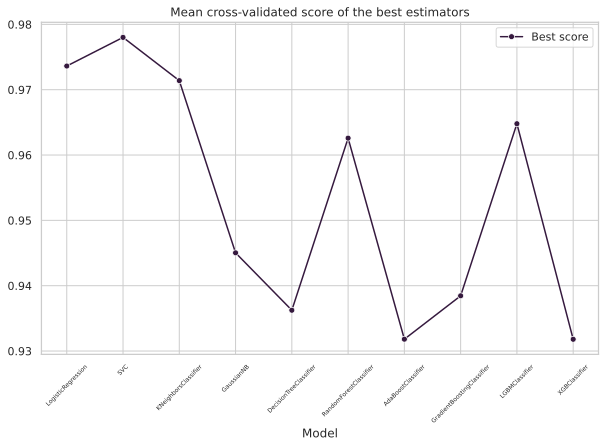

In [40]:
# Plotting the mean cross-validated score of the best estimators
plt.figure(figsize=(10,6))
sns.lineplot(pd.DataFrame(best_scores, columns=['Model', 'Best score']).set_index('Model'), markers=True)
plt.xticks(fontsize=6, rotation=45)
plt.title('Mean cross-validated score of the best estimators')

In [41]:
# Storing the new prediction outcomes in a dataframe
df_new_pred = pd.DataFrame(new_scores, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 score'])
df_new_pred

,Model,Accuracy,Precision,Recall,F1 score
0,LogisticRegression,0.96491,0.97500,0.92857,0.95122
1,SVC,0.96491,0.97500,0.92857,0.95122
2,KNeighborsClassifier,0.95614,0.97436,0.90476,0.93827
3,GaussianNB,0.93860,0.97297,0.85714,0.91139
4,DecisionTreeClassifier,0.94737,0.97368,0.88095,0.92500
5,RandomForestClassifier,0.96491,1.00000,0.90476,0.95000
6,AdaBoostClassifier,0.90351,0.96970,0.76190,0.85333
7,GradientBoostingClassifier,0.92982,0.94737,0.85714,0.90000
8,LGBMClassifier,0.96491,1.00000,0.90476,0.95000
9,XGBClassifier,0.94737,1.00000,0.85714,0.92308


Text(0.5, 1.0, 'Model new predictions on testing set')

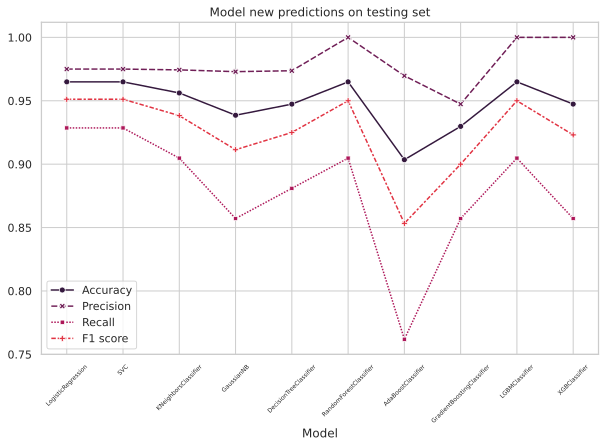

In [42]:
# Plotting the new predictions of models
plt.figure(figsize=(10,6))
sns.lineplot(df_new_pred.set_index('Model'), markers=True)
plt.xticks(fontsize=6, rotation=45)
plt.title('Model new predictions on testing set')

### **4. Ensemble Method**

**4.1 Stacking Ensemble**

In [43]:
# Initialising Stacking Classifier
estimators = [
    ('logistic_reg', LogisticRegression(C=1, max_iter=100, penalty='l2')),
    ('svm', SVC(C=1, degree=3, max_iter=100)),
    ('random_forest_classifier', RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50)),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='uniform')),
    ('lgbm_classifier', LGBMClassifier(learning_rate=0.01, max_depth=7, num_iterations=1000, verbosity=-1))
]

stacking_classifier = StackingClassifier(
    estimators = estimators,
    final_estimator=LogisticRegression()
)

In [44]:
# Cross validation score for Stacking Classifier
stacking_classifier.fit(X_train_transformed, y_train)
stacking_pred = stacking_classifier.predict(X_test_transformed)

stacking_metric = metrics(y_test, stacking_pred)
print(f"Accuracy: {stacking_metric[0]}")
print(f"Precision: {stacking_metric[1]}")
print(f"Recall: {stacking_metric[2]}")
print(f"F1 score: {stacking_metric[3]}")

Accuracy: 0.99123
Precision: 1.0
Recall: 0.97619
F1 score: 0.98795


**4.2 Voting Ensemble**

In [45]:
# Initialising Voting Classifier
estimators = [
    ('stacking_classifier', stacking_classifier),
    ('logistic_reg', LogisticRegression(C=1, max_iter=100, penalty='l2')),
    ('svm', SVC(C=1, degree=3, max_iter=100)),
    ('random_forest_classifier', RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50)),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='uniform')),
    ('lgbm_classifier', LGBMClassifier(learning_rate=0.01, max_depth=7, num_iterations=1000, verbosity=-1))
]

voting_classifier = VotingClassifier(
    estimators = estimators,
    voting = 'hard'
)

In [46]:
# Cross validation score for Voting Classifier
voting_classifier.fit(X_train_transformed, y_train)
voting_pred = voting_classifier.predict(X_test_transformed)

voting_metric = metrics(y_test, voting_pred)
print(f"Accuracy: {voting_metric[0]}")
print(f"Precision: {voting_metric[1]}")
print(f"Recall: {voting_metric[2]}")
print(f"F1 score: {voting_metric[3]}")

Accuracy: 0.97368
Precision: 1.0
Recall: 0.92857
F1 score: 0.96296


**OBSERVATION:**

Since, **Stacking Classifier** gives the best possible values for accuracy, precision, recall & f1-score it can be considered as the final model for Breast Cancer Prediction.

## **Model Evaluation**

In [47]:
# Initialising final model
estimators = [
    ('logistic_reg', LogisticRegression(C=1, max_iter=100, penalty='l2')),
    ('svm', SVC(C=1, degree=3, max_iter=100)),
    ('random_forest_classifier', RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50)),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='uniform')),
    ('lgbm_classifier', LGBMClassifier(learning_rate=0.01, max_depth=7, num_iterations=1000, verbosity=-1))
]

clf = StackingClassifier(
    estimators = estimators,
    final_estimator=LogisticRegression()
)
clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)

In [48]:
# Evaluation metrics
eval_metrics = metrics(y_test, y_pred)
print(f"Accuracy: {eval_metrics[0]}")
print(f"Precision: {eval_metrics[1]}")
print(f"Recall: {eval_metrics[2]}")
print(f"F1 score: {eval_metrics[3]}")

Accuracy: 0.99123
Precision: 1.0
Recall: 0.97619
F1 score: 0.98795


Text(0.5, 1.0, 'Confusion Matrix')

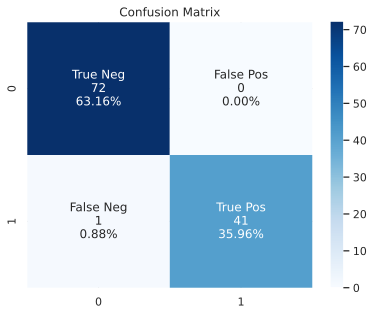

In [49]:
# Plotting Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

Text(0.5, 1.0, 'ROC Curve')

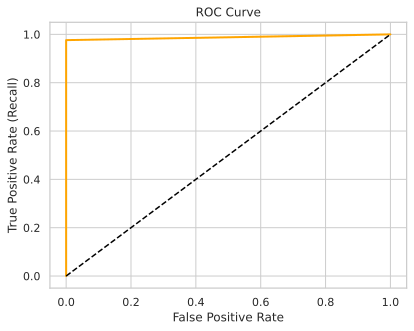

In [50]:
# Plotting the roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linewidth=2, color='orange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')

In [51]:
# Saving the model to a .pkl file
with open('/content/model.pkl', 'wb') as f:
    pickle.dump(clf, f)